In [2]:

import torch
# from tbparse import SummaryReader
from functools import partial
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
# import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
from adjustText import adjust_text
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 12})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
MODEL_NAME_MAP = {'BioBERT': 'BioBERT', 'bio-distilbert': 'BioDistilBERT',
                  'bio-mobilebert': 'BioMobileBERT', 'tiny-biobert': 'TinyBioBERT',
                  'Llama-2-7b': 'Llama-2-7b'}
HUE_ORDER = ['BioBERT',  'BioDistilBERT', 'BioMobileBERT', 'TinyBioBERT', 
             'Llama-2-7b']
PALETTE = 'Set2'
save_path = "/mnt/sdd/efficient_ml_data/figures_and_plots/"


# Overview: Load tensorboard files and plot them

Notebook to load in events files and plot them / save etc

## function development

In [186]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "mimic-roberta-base/declutr/2_anch_2_pos_min_1024": "Mimic-RoBERTa-DeCLUTR",
    "Bio_ClinicalBERT": "Bio-ClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
    "all-mpnet-base-v2 ": "all-mpnet-base-v2",
    "biobert-v1.1": "BioBERT",
    "Llama-2-7b-hf": "Llama-2-7b",
    "bert-base-uncased": "BERT-base",
    "distilbert-base-uncased": "DistilBERT-base",
    "google/mobilebert-uncased": "MobileBERT",
    "prajjwal1/bert-tiny": "TinyBERT",
    }

# task name mappings

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",
                      "ICD9-Triage": "ICD9-Triage"}

def get_configs(logs_dir, modeldir):
    # try open but skip if doesn't exist
    try:
        with open(logs_dir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(f"{logdir}/", extra_columns={'dir_name', 'wall_time'})
    df = reader.scalars
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(
        lambda x: partial(get_configs, logdir)(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')

    # we want to replace few_shot_n nan values with few_shot_n = "full"
    # check if few_shot_n is a column
    if "few_shot_n" in merged_df.columns:
        merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))

    # now map to a more suitable name
    merged_df["Model name"] = merged_df["Model name"].replace(long_model_name_mappings)
    
    
    return merged_df

def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",                     
                    sample_sizes = None, 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df.loc[logs_df['tag'].str.contains('|'.join(metrics))]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            task_type = "SEQ_CLS", # | TOKEN_CLS
                            value_aggregate_method = "mean",
                            log_collection = "all", # | span
                            plm = "Frozen" # | Finetuned
                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        
        
        
        
        tb_metrics = extract_metric( logs_df,  metrics = metric,
                                            mode = mode)
        
        # drop rows that are != task_type and if task_type is not specified then keep all
        if task_type is not None:
            
            tb_metrics = tb_metrics[tb_metrics['task_type'] == task_type]

        # remove eval from the tag column
        # tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"eval/",'')
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"test/",'')
        
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

### Get number of trainable parameters for each model type



In [187]:
with open('../trainable_params.yaml', 'r') as f:
    trainable_params_mapping = yaml.load(f, yaml.FullLoader)

with open('../model_type_trainable_model_size.yaml', 'r') as f:
    model_type_size_mappings = yaml.load(f, yaml.FullLoader)

with open('../gpu_memory_needed.json', 'r') as f:
    gpu_memory_needed = yaml.load(f, yaml.FullLoader)

In [188]:
list(trainable_params_mapping.keys())

['bert-base-uncased',
 'distilbert-base-uncased',
 'dmis-lab/biobert-v1.1',
 'emilyalsentzer/Bio_ClinicalBERT',
 'google/mobilebert-uncased',
 'huawei-noah/TinyBERT_General_4L_312D',
 'meta-llama/Llama-2-7b-hf',
 'nlpie/bio-distilbert-uncased',
 'nlpie/bio-mobilebert',
 'nlpie/clinical-distilbert',
 'nlpie/clinical-mobilebert',
 'nlpie/distil-biobert',
 'nlpie/tiny-biobert',
 'nlpie/tiny-clinicalbert',
 'prajjwal1/bert-tiny',
 'roberta-base']

In [189]:
gpu_memory_needed

{'nlpie/bio-mobilebert': 0.09157848358154297,
 'nlpie/tiny-biobert': 0.05176830291748047,
 'roberta-base': 0.46604251861572266,
 'nlpie/distil-biobert': 0.24604511260986328,
 'dmis-lab/biobert-v1.1': 0.40447139739990234,
 'meta-llama/Llama-2-7b-hf': 24.739288330078125}

## Sensitivity analysis


### Time budget

In [7]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/tb_2000/logs/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))
fs_logs_df = fs_logs_df.loc[fs_logs_df['Model name'].isin(
    ['Llama-2-7b', 'RoBERTa-base', 'BioBERT', 'bio-mobilebert', 
     'bio-distilbert-uncased', 'tiny-biobert'])]
fs_logs_df.loc[fs_logs_df['Model name'] == 'bio-distilbert-uncased', 'Model name'] = 'bio-distilbert'

fs_logs_df.shape

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/48339 [00:00<?, ?it/s]

(43014, 63)

In [8]:
llama_logs = fs_logs_df.loc[fs_logs_df['Model name'] == 'Llama-2-7b']
fs_logs_df = fs_logs_df.loc[fs_logs_df['scheduler_type'] == 'linear']
fs_logs_df = pd.concat((fs_logs_df, llama_logs))

# Group by model name and peft method and keep all rows with only the
# latest datetime
fs_logs_df = fs_logs_df.loc[fs_logs_df.groupby(
    ['Model name', 'peft_method'])['datetime'].transform(
        lambda x: x == x.max()).reindex()]

fs_logs_df.shape

(19506, 63)

In [9]:
fs_logs_df.groupby(['Model name', 'peft_method'])['datetime'].value_counts()

Model name      peft_method  datetime           
BioBERT         Full         2024-01-05 15:45:00    2304
                LORA         2024-01-05 12:55:00    2304
Llama-2-7b      LORA         2024-01-04 09:30:00     621
RoBERTa-base    Full         2024-01-26 11:07:00     774
                LORA         2024-01-26 09:46:00     774
bio-distilbert  Full         2024-01-11 11:27:00     549
                LORA         2024-01-11 10:53:00     600
bio-mobilebert  Full         2024-01-05 17:22:00    1389
                LORA         2024-01-04 17:11:00    1581
tiny-biobert    Full         2024-01-04 19:36:00    4011
                LORA         2024-01-04 19:01:00    4599
Name: count, dtype: int64

/tmp/ipykernel_56591/3333112472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Time (s)'] = plot_df.groupby(['Model name', 'peft_method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values


NameError: name 'save_path' is not defined

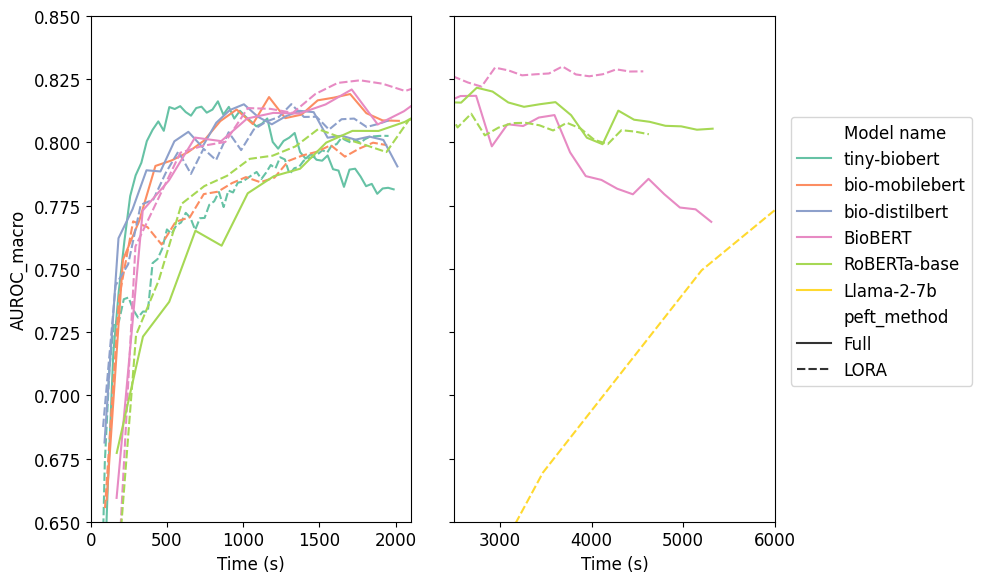

In [10]:
plot_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'peft_method']]
plot_df['Time (s)'] = plot_df.groupby(['Model name', 'peft_method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
plot_df = plot_df.loc[plot_df['tag'].str.contains('eval/roc_auc')]
plot_df.rename(columns={'value': 'AUROC_macro'}, inplace=True)
# fg = sns.FacetGrid(data=plot_df, col='peft_method', sharey=True, sharex=True, 
#                    legend_out=True, aspect = 1, height = 4, 
#                    col_order=['Full', 'LORA'])
# fg.map_dataframe(sns.lineplot, x='rel_time', y='value', hue='Model name', 
#                  hue_order=plot_df['Model name'].unique(), palette='Set2')
# fg.add_legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=False)
ax = ax.flatten()
for ax_num, xrange in enumerate([(0, 2100), (2500, 6000)]):
    sns.lineplot(data=plot_df, x='Time (s)', y='AUROC_macro', 
                hue='Model name', hue_order=HUE_ORDER, 
                style='peft_method', style_order=['Full', 'LORA'], 
                palette=PALETTE, ax=ax[ax_num], legend=ax_num==len(ax)-1)
    ax[ax_num].set_xlim(xrange)
    ax[ax_num].set_ylim((0.65, 0.85))

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()



### Fewshot budget

In [36]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/fewshot_budget_multiseed/logs/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))

fs_logs_df = fs_logs_df.loc[fs_logs_df['Model name'].isin(
    ['Llama-2-7b', 'BioBERT', 'bio-mobilebert', 
     'bio-distilbert-uncased', 'tiny-biobert'])]
fs_logs_df.loc[fs_logs_df['Model name'] == 'bio-distilbert-uncased', 'Model name'] = 'bio-distilbert'

fs_logs_df.shape

  0%|          | 0/221 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdh/effecient_ml/fewshot_budget_multiseed/logs/mimic-mp/fewshot_256/Llama-2-7b-hf/LORA/13-02-2024--11-50/config.yaml'


  0%|          | 0/34875 [00:00<?, ?it/s]

(34875, 64)

In [37]:
fs_cls_results_df = produce_results_table(fs_logs_df,
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task", "few_shot_n", "peft_method", "random_seed"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

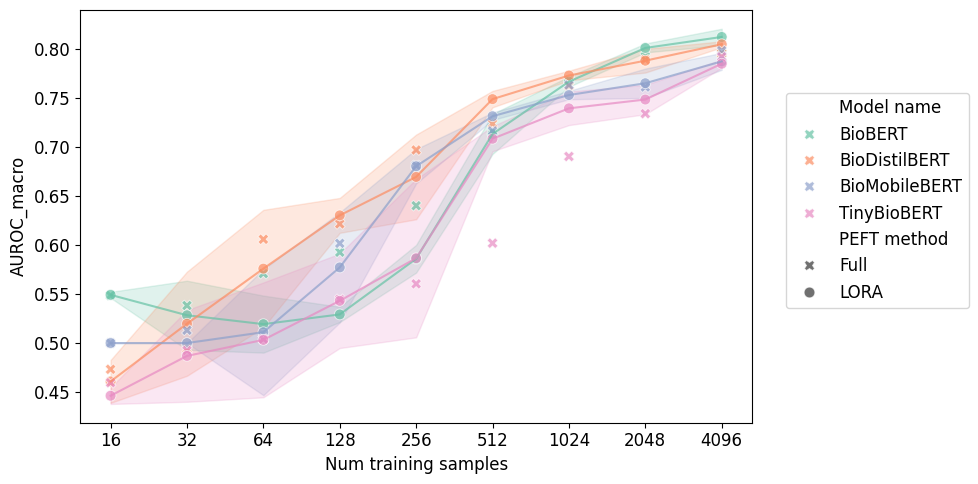

In [46]:
# same as above but with facet
plot_df = fs_cls_results_df.loc[fs_cls_results_df['Model name'] != 'Llama-2-7b'].copy()
plot_df['Model name'] = plot_df['Model name'].replace(MODEL_NAME_MAP)
plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(int).astype(str)
plot_df.rename(columns={'few_shot_n': 'Num training samples', 
                        'roc_auc_macro':'AUROC_macro',
                        'peft_method': 'PEFT method'}, inplace=True)
metrics = ['AUROC_macro']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=plot_df.loc[plot_df['PEFT method'] == 'LORA'], 
                  x='Num training samples', y=metric, errorbar='sd',
                  hue='Model name', hue_order = HUE_ORDER[:-1],
                  alpha=0.7, linewidth=1.5, palette=PALETTE, legend=False)
    sns.scatterplot(data=plot_df.groupby(['Model name', 'Num training samples', 'PEFT method'])[metric].mean().reset_index(),
                  x='Num training samples', y=metric, 
                  hue='Model name', hue_order = HUE_ORDER[:-1],
                  style='PEFT method', style_order=['Full', 'LORA'],
                  alpha=0.7, markers=['X', 'o'], s=60, palette=PALETTE)
    plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'{save_path}/fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.show()

### AWS cost calculation

In [123]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/tb_2000/logs/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))
fs_logs_df = fs_logs_df.loc[fs_logs_df['Model name'].isin(
    ['Llama-2-7b', 'RoBERTa-base', 'BioBERT', 'bio-mobilebert', 
     'bio-distilbert-uncased', 'tiny-biobert'])]
fs_logs_df.loc[fs_logs_df['Model name'] == 'bio-distilbert-uncased', 'Model name'] = 'bio-distilbert'

fs_logs_df = fs_logs_df.loc[(fs_logs_df['scheduler_type'] == 'linear') | 
                            (fs_logs_df['Model name'] == 'Llama-2-7b')]

# Group by model name and peft method and keep all rows with only the
# latest datetime
fs_logs_df = fs_logs_df.loc[fs_logs_df.groupby(
    ['Model name', 'peft_method'])['datetime'].transform(
        lambda x: x == x.max()).reindex()]

fs_logs_df.groupby(['Model name', 'peft_method'])['datetime'].value_counts()

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/48339 [00:00<?, ?it/s]

Model name      peft_method  datetime           
BioBERT         Full         2024-01-05 15:45:00    2304
                LORA         2024-01-05 12:55:00    2304
Llama-2-7b      LORA         2024-01-04 09:30:00     621
RoBERTa-base    Full         2024-01-26 11:07:00     774
                LORA         2024-01-26 09:46:00     774
bio-distilbert  Full         2024-01-11 11:27:00     549
                LORA         2024-01-11 10:53:00     600
bio-mobilebert  Full         2024-01-05 17:22:00    1389
                LORA         2024-01-04 17:11:00    1581
tiny-biobert    Full         2024-01-04 19:36:00    4011
                LORA         2024-01-04 19:01:00    4599
Name: count, dtype: int64

In [124]:
fs_logs_df['tag'].unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'test/accuracy', 'test/f1_macro',
       'test/f1_micro', 'test/f1_weighted', 'test/loss', 'test/precision',
       'test/recall', 'test/roc_auc_macro', 'test/runtime',
       'test/samples_per_second', 'test/steps_per_second', 'train/epoch',
       'train/learning_rate', 'train/loss', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second'],
      dtype=object)

In [131]:
time_df = fs_logs_df[['step', 'tag', 'value', 'Model name', 'peft_method']]
time_df = time_df.loc[time_df['tag'].isin(['eval/runtime', 'train/train_runtime', 'train/epoch'])]
time_df = time_df.pivot_table(index=['step', 'Model name', 'peft_method'], 
                                    columns='tag', values='value').reset_index()
time_df['train/time_10epochs'] = (time_df['train/train_runtime'] / time_df['train/epoch']) * 10
time_df['eval/runtime_100K_samples'] = (time_df['eval/runtime'] / 4900) * 100_000
time_df['eval_time_100K_samples'] = time_df.groupby(['Model name', 'peft_method'])['eval/runtime_100K_samples'].transform(lambda x: np.nanmean(x)).reindex().values
time_df['train_time_10_epochs'] = time_df.groupby(['Model name', 'peft_method'])['train/time_10epochs'].transform(lambda x: np.nanmean(x)).reindex().values
time_df.drop_duplicates(['Model name', 'peft_method', 'eval_time_100K_samples', 'train_time_10_epochs'], inplace=True)
time_df.rename(columns={'eval_time_100K_samples': 'Eval time (s)', 
                        'train_time_10_epochs': 'Train time (s)'}, inplace=True)
time_df['Train time (hr)'] = time_df['Train time (s)'] / 3600
time_df['Eval time (hr)'] = time_df['Eval time (s)'] / 3600
time_df = time_df.filter(['Model name', 'peft_method', 'Train time (hr)', 'Eval time (hr)'])
time_df

tag,Model name,peft_method,Train time (hr),Eval time (hr)
0,BioBERT,Full,2.511050,0.220628
1,BioBERT,LORA,2.157222,0.222877
2,Llama-2-7b,LORA,51.071628,4.057080
3,RoBERTa-base,Full,2.518249,0.217757
4,RoBERTa-base,LORA,2.186320,0.225492
5,bio-distilbert,Full,1.350767,0.123225
6,bio-distilbert,LORA,1.208238,0.130376
7,bio-mobilebert,Full,1.569641,0.140627
8,bio-mobilebert,LORA,1.352405,0.140789
9,tiny-biobert,Full,0.531881,0.061752


In [132]:
aws_rate = pd.read_csv('/mnt/sdd/efficient_ml_data/AWS_EC2_ratecard.csv')
aws_rate = aws_rate.loc[~aws_rate['GPUs'].isna()]
training_cost = np.mean(aws_rate.loc[aws_rate['EC2 Instance Type'] == 'g5.16xlarge'][['On-demand GBP/hr', 'Spot GBP/hr']].values[0])
inference_cost = np.mean(aws_rate.loc[aws_rate['EC2 Instance Type'] == 'g4dn.16xlarge'][['On-demand GBP/hr', 'Spot GBP/hr']].values[0])

In [140]:
time_df['Training cost (GBP)'] = time_df['Train time (hr)'] * training_cost
time_df['Inference cost (GBP)'] = time_df['Eval time (hr)'] * inference_cost
time_df['Total cost (GBP)'] = time_df['Training cost (GBP)'] + time_df['Inference cost (GBP)']
time_df = time_df.round(2)

In [141]:
time_df.sort_values('Total cost (GBP)', ascending=False)
time_cost_table = time_df.filter(['Model name', 'peft_method', 'Train time (hr)', 'Eval time (hr)', 'Total cost (GBP)'])
time_cost_table.rename(columns={'peft_method':'PEFT Method', 'Eval time (hr)':'Inference time (hr)'}, inplace=True)
time_cost_table.sort_values(['Model name', 'PEFT Method'], inplace=True)
print(time_cost_table.to_latex(float_format="%.2f",index = False))

\begin{tabular}{llrrr}
\toprule
Model name & PEFT Method & Train time (hr) & Inference time (hr) & Total cost (GBP) \\
\midrule
BioBERT & Full & 2.51 & 0.22 & 5.56 \\
BioBERT & LORA & 2.16 & 0.22 & 4.84 \\
Llama-2-7b & LORA & 51.07 & 4.06 & 112.22 \\
RoBERTa-base & Full & 2.52 & 0.22 & 5.58 \\
RoBERTa-base & LORA & 2.19 & 0.23 & 4.92 \\
bio-distilbert & Full & 1.35 & 0.12 & 2.99 \\
bio-distilbert & LORA & 1.21 & 0.13 & 2.73 \\
bio-mobilebert & Full & 1.57 & 0.14 & 3.48 \\
bio-mobilebert & LORA & 1.35 & 0.14 & 3.03 \\
tiny-biobert & Full & 0.53 & 0.06 & 1.20 \\
tiny-biobert & LORA & 0.46 & 0.06 & 1.06 \\
\bottomrule
\end{tabular}



### Efficiency plot

In [177]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/tb_2000/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df = fs_logs_df.loc[fs_logs_df['Model name'].isin(
    ['BioBERT', 'bio-mobilebert', 'bio-distilbert-uncased', 
     'tiny-biobert', 'Llama-2-7b'])]
fs_logs_df.loc[fs_logs_df['Model name'] == 'bio-distilbert-uncased', 'Model name'] = 'bio-distilbert'
fs_logs_df = fs_logs_df.loc[(fs_logs_df['scheduler_type'] == 'linear') | 
                            (fs_logs_df['Model name'] == 'Llama-2-7b')]

# Group by model name and peft method and keep all rows with only the
# latest datetime
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))
fs_logs_df = fs_logs_df.loc[fs_logs_df.groupby(
    ['Model name', 'peft_method'])['datetime'].transform(
        lambda x: x == x.max()).reindex()]

fs_logs_df.shape

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/48339 [00:00<?, ?it/s]

(17958, 63)

In [190]:
eff_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'task', 'peft_method']]
eff_df = eff_df.loc[eff_df['task'] == 'mimic-mp']
eff_df['rel_time'] = eff_df.groupby(['Model name', 'peft_method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
best_rel_time = eff_df.loc[eff_df['tag'] == 'eval/roc_auc_macro'][['Model name', 'peft_method', 'rel_time', 'value']]
best_rel_time = best_rel_time.groupby(['Model name', 'peft_method']).apply(lambda x: x.nlargest(1, 'value')).reset_index(drop=True)
best_rel_time.index = best_rel_time.apply(lambda x: f'{x["Model name"]}_{x["peft_method"]}', axis=1).values
best_rel_time

,Model name,peft_method,rel_time,value
BioBERT_Full,BioBERT,Full,1711.727385,0.820937
BioBERT_LORA,BioBERT,LORA,3682.192133,0.830042
Llama-2-7b_LORA,Llama-2-7b,LORA,27785.839342,0.846324
bio-distilbert_Full,bio-distilbert,Full,1004.891235,0.815090
bio-distilbert_LORA,bio-distilbert,LORA,1315.923866,0.815145
bio-mobilebert_Full,bio-mobilebert,Full,1701.496536,0.819139
bio-mobilebert_LORA,bio-mobilebert,LORA,1851.689334,0.799893
tiny-biobert_Full,tiny-biobert,Full,834.436443,0.816259
tiny-biobert_LORA,tiny-biobert,LORA,1922.244247,0.802615


In [191]:
# Add up all evaltimes and test times because tensorboard logs them for
# each evaluation or test loop
eval_time_df = produce_results_table(fs_logs_df,
                    metric = ["eval/runtime", "test/runtime"],
                    mode = "all",
                    groupby_list = ["Model name", "model_name_or_path", 
                                    "task", "few_shot_n", "peft_method"],
                    task_type = "SEQ_CLS",
                    value_aggregate_method = "sum",
                    )
# Do not add up train time because tensorboard logs the total train
# time, not for each epoch
train_time_df = produce_results_table(fs_logs_df,
                    metric = ["train/total_flos", "train/train_runtime"],
                    mode = "all",
                    groupby_list = ["Model name", "model_name_or_path", 
                                    "task", "few_shot_n", "peft_method"],
                    task_type = "SEQ_CLS",
                    value_aggregate_method = "max",
                    )

In [192]:
time_df = pd.merge(eval_time_df, train_time_df, on=['Model name', 'model_name_or_path', 'task', 'few_shot_n', 'peft_method'])
time_df['eval_test_time'] = time_df['eval/runtime'] + time_df['runtime']
time_df = time_df[['Model name', 'model_name_or_path', 'peft_method', 'eval_test_time', 'train/total_flos', 'train/train_runtime']]
time_df.index = time_df.apply(lambda x: f'{x["Model name"]}_{x["peft_method"]}', axis=1).values
time_df['best_rel_time'] = best_rel_time.loc[time_df.index, 'rel_time'].values
time_df['best_rel_time'] = time_df['best_rel_time'] - time_df['eval_test_time']
time_df['best_flos'] = (time_df['train/total_flos'] / time_df['train/train_runtime']) * time_df['best_rel_time']
time_df['best_value'] = best_rel_time.loc[time_df.index, 'value'].values

In [193]:
time_df

tag,Model name,model_name_or_path,peft_method,eval_test_time,train/total_flos,train/train_runtime,best_rel_time,best_flos,best_value
BioBERT_Full,BioBERT,dmis-lab/biobert-v1.1,Full,1281.853882,5.025178e+16,5423.868164,429.873503,3.982750e+15,0.820937
BioBERT_LORA,BioBERT,dmis-lab/biobert-v1.1,LORA,1294.973595,5.059875e+16,4659.600098,2387.218538,2.592288e+16,0.830042
Llama-2-7b_LORA,Llama-2-7b,meta-llama/Llama-2-7b-hf,LORA,19320.627930,1.398980e+18,43390.453125,8465.211413,2.729324e+17,0.846324
bio-distilbert_Full,bio-distilbert,nlpie/bio-distilbert-uncased,Full,519.400105,1.747467e+16,2013.183594,485.491131,4.214119e+15,0.815090
bio-distilbert_LORA,bio-distilbert,nlpie/bio-distilbert-uncased,LORA,595.615391,2.005014e+16,2000.842651,720.308475,7.218100e+15,0.815145
bio-mobilebert_Full,bio-mobilebert,nlpie/bio-mobilebert,Full,518.702200,7.145362e+15,2022.952759,1182.794336,4.177801e+15,0.819139
bio-mobilebert_LORA,bio-mobilebert,nlpie/bio-mobilebert,LORA,569.788700,8.560593e+15,2001.018555,1281.900634,5.484122e+15,0.799893
tiny-biobert_Full,tiny-biobert,nlpie/tiny-biobert,Full,618.653899,4.771707e+15,2000.935547,215.782544,5.145848e+14,0.816259
tiny-biobert_LORA,tiny-biobert,nlpie/tiny-biobert,LORA,646.195102,5.852876e+15,1970.063843,1276.049145,3.791023e+15,0.802615


In [194]:
time_df["PEFT_params"] = time_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('n_peft_params', np.NaN), axis=1)
time_df

tag,Model name,model_name_or_path,peft_method,eval_test_time,train/total_flos,train/train_runtime,best_rel_time,best_flos,best_value,PEFT_params
BioBERT_Full,BioBERT,dmis-lab/biobert-v1.1,Full,1281.853882,5.025178e+16,5423.868164,429.873503,3.982750e+15,0.820937,108310272
BioBERT_LORA,BioBERT,dmis-lab/biobert-v1.1,LORA,1294.973595,5.059875e+16,4659.600098,2387.218538,2.592288e+16,0.830042,294912
Llama-2-7b_LORA,Llama-2-7b,meta-llama/Llama-2-7b-hf,LORA,19320.627930,1.398980e+18,43390.453125,8465.211413,2.729324e+17,0.846324,4194304
bio-distilbert_Full,bio-distilbert,nlpie/bio-distilbert-uncased,Full,519.400105,1.747467e+16,2013.183594,485.491131,4.214119e+15,0.815090,66953472
bio-distilbert_LORA,bio-distilbert,nlpie/bio-distilbert-uncased,LORA,595.615391,2.005014e+16,2000.842651,720.308475,7.218100e+15,0.815145,811776
bio-mobilebert_Full,bio-mobilebert,nlpie/bio-mobilebert,Full,518.702200,7.145362e+15,2022.952759,1182.794336,4.177801e+15,0.819139,24581888
bio-mobilebert_LORA,bio-mobilebert,nlpie/bio-mobilebert,LORA,569.788700,8.560593e+15,2001.018555,1281.900634,5.484122e+15,0.799893,221184
tiny-biobert_Full,tiny-biobert,nlpie/tiny-biobert,Full,618.653899,4.771707e+15,2000.935547,215.782544,5.145848e+14,0.816259,13874136
tiny-biobert_LORA,tiny-biobert,nlpie/tiny-biobert,LORA,646.195102,5.852876e+15,1970.063843,1276.049145,3.791023e+15,0.802615,59904


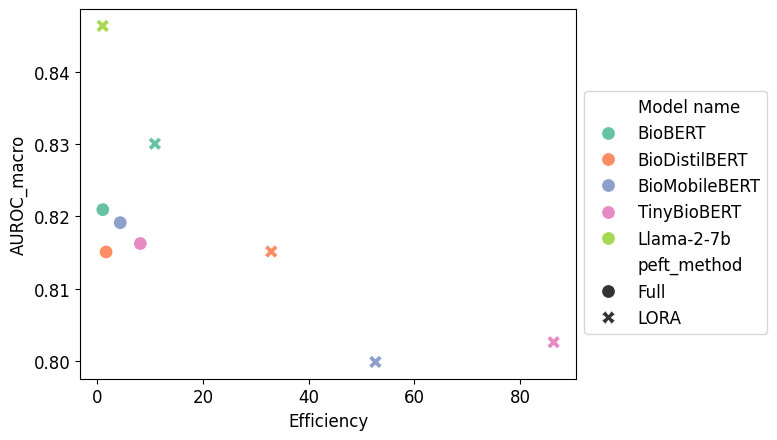

,Model name,peft_method,best_flos,AUROC_macro,PEFT_params,Efficiency
8,TinyBioBERT,LORA,0.012005,0.802615,0.000000,86.324276
6,BioMobileBERT,LORA,0.018208,0.799893,0.001489,52.611396
4,BioDistilBERT,LORA,0.024561,0.815145,0.006942,32.894936
1,BioBERT,LORA,0.093094,0.830042,0.002170,10.878105
7,TinyBioBERT,Full,0.000000,0.816259,0.127543,8.124988
5,BioMobileBERT,Full,0.013422,0.819139,0.226405,4.320981
3,BioDistilBERT,Full,0.013555,0.815090,0.617611,1.641862
0,BioBERT,Full,0.012707,0.820937,0.999447,1.023843
2,Llama-2-7b,LORA,0.998115,0.846324,0.038172,1.000000


In [198]:
plot_df = time_df.filter(['Model name', 'peft_method', 'best_flos', 'best_value', 'PEFT_params']).reset_index(drop=True)
plot_df.columns.name = None
plot_df['Model name'] = plot_df['Model name'].replace(MODEL_NAME_MAP)
for c in ['best_flos', 'PEFT_params']:
    plot_df[c] = (plot_df[c] - plot_df[c].min())/plot_df[c].max()

# Efficiency = how many times more efficient than Llama
plot_df['Efficiency'] = plot_df['best_flos'] + plot_df['PEFT_params']
plot_df['Efficiency'] = plot_df['Efficiency']/plot_df['Efficiency'].max()
plot_df['Efficiency'] = 1/plot_df['Efficiency']


plot_df = plot_df.rename(columns={'best_value': 'AUROC_macro'})
sns.scatterplot(data=plot_df, x='Efficiency', y='AUROC_macro', 
                hue='Model name', hue_order=HUE_ORDER,
                style='peft_method', style_order=['Full', 'LORA'],
                s=100, palette=PALETTE)
plt.legend(bbox_to_anchor=(1, 0.8), loc=2)
plt.show()
plot_df.sort_values('Efficiency', ascending=False)